In [1]:
from datascience import *
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter("ignore")

## Review

In [2]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

In [4]:
def distance(pt1, pt2):
    """The distance between two points, represented as arrays."""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """The distance between two rows of a table."""
    return distance(np.array(row1), np.array(row2))

def distances(training, example, output):
    """Compute the distance from example for each row in training."""
    dists = []
    attributes = training.drop(output)
    for row in attributes.rows:
        dists.append(row_distance(row, example))
    return training.with_column('Distance', dists)

def closest(training, example, k, output):
    """Return a table of the k closest neighbors to example."""
    return distances(training, example, output).sort('Distance').take(np.arange(k))


## New material

In [5]:
all_sales = Table.read_table('house.csv')

In [7]:
sales = all_sales.where('Bldg Type', '1Fam').where('Sale Condition', 'Normal').select(
    'SalePrice', '1st Flr SF', '2nd Flr SF', 
    'Total Bsmt SF', 'Garage Area', 
    'Wood Deck SF', 'Open Porch SF', 'Lot Area', 
    'Year Built', 'Yr Sold')

Exploration!

In [8]:
sales.num_rows

2002

In [9]:
sales.sample(6).show(6)

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
122000,864,0,864,440,158,0,9079,1961,2009
200000,854,840,569,434,0,382,8314,1997,2006
155000,1128,0,1120,525,192,20,8700,1963,2008
194500,1086,809,712,409,143,46,10832,1994,2008
96500,792,348,576,0,0,160,8800,1910,2010
137000,1024,704,704,234,245,60,9462,1949,2006


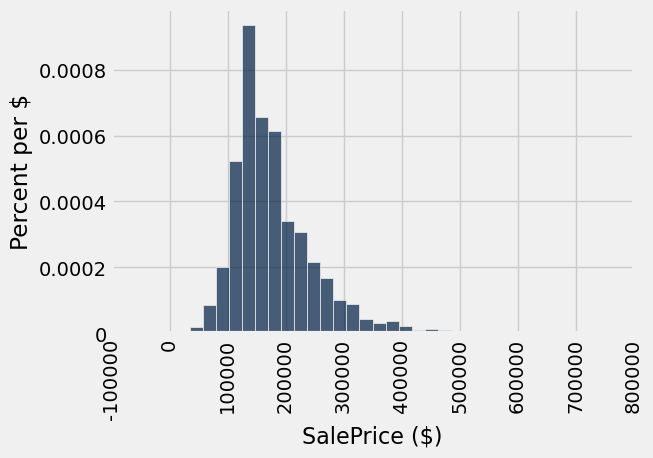

In [10]:
sales.hist('SalePrice', bins=32, unit='$')

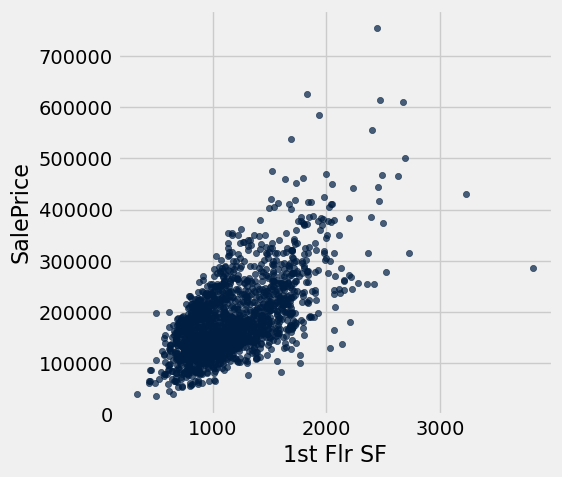

In [11]:
sales.scatter('1st Flr SF', 'SalePrice')

In [12]:
correlation(sales, 'SalePrice', '1st Flr SF')

0.64246625410302249

- It's always a good idea to take a look at each of the variables in some capacity.
    -  To make the demo shorter we will just look at the $r$ for each variable, but you should look at the plots as well.

In [13]:
for label in sales.labels:
    print('Correlation of', label, 'and SalePrice:\t', correlation(sales, label, 'SalePrice'))

Correlation of SalePrice and SalePrice:	 1.0
Correlation of 1st Flr SF and SalePrice:	 0.642466254103
Correlation of 2nd Flr SF and SalePrice:	 0.35752189428
Correlation of Total Bsmt SF and SalePrice:	 0.652978626757
Correlation of Garage Area and SalePrice:	 0.638594485252
Correlation of Wood Deck SF and SalePrice:	 0.352698666195
Correlation of Open Porch SF and SalePrice:	 0.336909417026
Correlation of Lot Area and SalePrice:	 0.290823455116
Correlation of Year Built and SalePrice:	 0.565164753714
Correlation of Yr Sold and SalePrice:	 0.0259485790807


______

### Linear regression but with more predictor variables!

This is a 50/50 train-test split.

In [18]:
train, test = sales.split(k = round(sales.num_rows/2))

In [23]:
def predict(slopes, row):
    return sum(slopes * np.array(row))

#### **Task:** Predict the sale price of the first house in the dataset.

In [21]:
train_prices = train.column(0)
train_attributes = train.drop(0)

In [22]:
test_prices = test.column(0)
test_attributes = test.drop(0)

In [24]:
def rmse(slopes, attributes, prices):
    errors = make_array()
    
    for i in np.arange(len(prices)):
        predicted = predict(slopes, attributes.row(i))
        actual = prices.item(i)
        errors = np.append(errors, (actual - predicted))
        
    return np.mean(errors ** 2) ** 0.5

In [25]:
def rmse_train(slopes):
    return rmse(slopes, train_attributes, train_prices)

In [26]:
def rmse_test(slopes):
    return rmse(slopes, test_attributes, test_prices)

In [27]:
example_row = test.drop('SalePrice').row(0)

##### Method 1: Slopes corresponding to each predictor variable are random

The prediction and thus, the residual, will change every time we run this code.

In [29]:
example_slopes = np.random.normal(10, 1, len(example_row))

In [30]:
example_prediction = predict(example_slopes, example_row)

In [32]:
example_prediction

146361.08854621463

In [33]:
example_residual = test.column('SalePrice').item(0) - example_prediction
example_residual

14138.911453785375

In [34]:
rmse_test(example_slopes)

101182.16046938805

##### Method 2: Slopes corresponding to each predictor variable are the best (as determined by minimization)

With regards to the `start` `smooth`, and `array` arguments:

- It is beyond the scope of this course to determine what starting values to use (for the slope) for a numerical optimization problem. You can use randomly generated slopes as created by `np.random.normal()` above, or we will just supply the slopes for you.
- A linear regression model is considered "smooth" in terms of the definition of the argument for this function.
- `array` will be `True` for a multiple linear regression problem because there are multiple starting values (multiple slopes)

In [36]:
best_slopes = minimize(rmse_train, 
                       start=example_slopes, 
                       smooth=True, 
                       array=True)

In [37]:
Table(train_attributes.labels).with_row(list(best_slopes)).show()

1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Wood Deck SF,Open Porch SF,Lot Area,Year Built,Yr Sold
79.9645,72.4746,40.7951,51.1416,24.9474,31.8805,0.521644,540.348,-535.799


**Discussion Question**

In [38]:
best_prediction = predict(best_slopes, example_row)

In [39]:
best_residual = test.column('SalePrice').item(0) - best_prediction
best_residual

5663.4771673569921

In [40]:
rmse_test(best_slopes)

32211.475352043897

### How did we do?

In [41]:
def fit(row):
    return sum(best_slopes * np.array(row))

**Discussion Question**

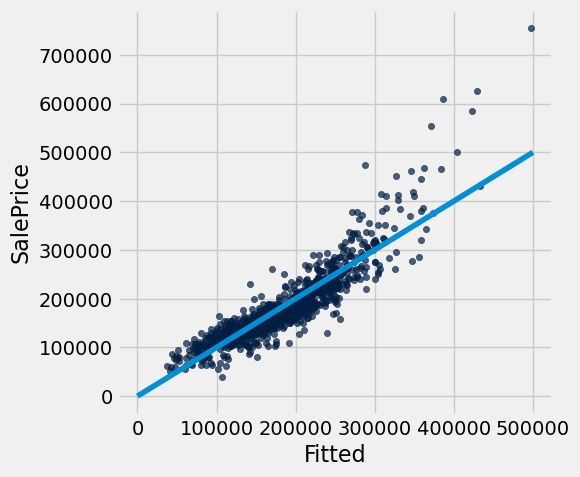

In [42]:
test.with_column('Fitted', test.drop(0).apply(fit)).scatter('Fitted', 0)
plt.plot([0, 5e5], [0, 5e5]);

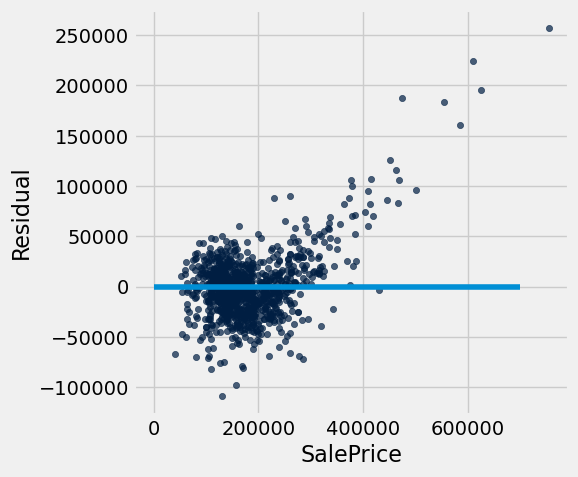

In [43]:
test.with_column('Residual', test_prices-test.drop(0).apply(fit)).scatter(0, 'Residual')
plt.plot([0, 7e5], [0, 0]);

### We can bring nearest neighbors to linear regression, too!

For ease of computational efficiency, we will use the five variables having the highest correlation coefficients with `SalePrice`.

In [45]:
train_nn = train.select(0, 1, 2, 3, 4, 8)
test_nn = test.select(0, 1, 2, 3, 4, 8)
train_nn.show(3)

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built
421250,1515,1134,1479,746,2001
88000,858,0,858,0,1971
133500,832,629,832,384,1949


In [46]:
example_nn_row = test_nn.drop(0).row(0)
closest(train_nn, example_nn_row, k=5, output='SalePrice')

SalePrice,1st Flr SF,2nd Flr SF,Total Bsmt SF,Garage Area,Year Built,Distance
142500,1003,0,1003,588,1984,63.5453
164000,1000,0,1000,575,1963,71.4563
128500,988,0,988,572,1961,75.5844
169000,1102,0,988,582,1980,76.0789
153500,1008,0,923,678,1977,78.981


In [47]:
def predict_nn(example):
    """Return the majority class among the k nearest neighbors."""
    return np.average(closest(train_nn, example, 5, 'SalePrice').column('SalePrice'))

In [48]:
nn_prediction = predict_nn(example_nn_row)

In [49]:
nn_prediction

151500.0

In [50]:
nn_residual = nn_prediction - test_nn.column('SalePrice').item(0) 
nn_residual

-9000.0

In [52]:
nn_test_predictions = test_nn.drop('SalePrice').apply(predict_nn)
rmse_nn = np.mean((test_prices - nn_test_predictions) ** 2) ** 0.5
rmse_nn

35790.965263600527